In [2]:
'''
    Outputs overall sentiment (with rounded polarity) and sentiment over time (frequency bins).
    Also computes overall average sentiment.
'''

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # plot sentiment over time

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# progress bar
from tqdm import tqdm
tqdm.pandas()

NUM_SEGMENTS = 34 # decided on 34 segments for overall data

# Input/output files for overall data
DATA_IN = "../datain/sentiment/cleaned_tweets_for_sentiment.csv"
ROUNDED_POLARITY_OUT = "../dataout/sentiment/rounded_sentiment_overall.jpeg"
SENTIMENT_OVER_TIME_PER_SEGMENT_OUT = '../dataout/sentiment/sentiment_per_segment_overall.jpeg'

In [5]:
def clean_sentiment_data(df):
    '''
        Load & clean data.

        Args:
            df: dataframe containing the sentiment data
        Returns:
            df: cleaned dataframe
    '''
    # remove all null created_at values from dataframe
    df = df.drop(df[df['created_at'].isnull()].index)
    df = df.drop(df[df['cleaned_tweet'].isnull()].index)
    # ensure that all values in created_at has 2021 (and not random strings)
    df = df[df['created_at'].str.contains("2021")]

    # split created_at into date and time columns
    # https://intellipaat.com/community/13909/python-how-can-i-split-a-column-with-both-date-and-time-e-g-2019-07-02-00-12-32-utc-into-two-separate-columns
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date
    df['time'] = df['created_at'].dt.time

    return df


def sentiment_polarity_score(df, overall=True, selected_topic=0, filename=ROUNDED_POLARITY_OUT):
    '''
        Calculates the sentiment polarity score.

        Args:
            df: cleaned dataframe with tweet data
            overall: boolean (true if want to analyse overall data frequency, false if not)
            selected_topic: the topic number of the topic to be analysed.
            filename: path to the file to which this function will output to.
        Returns:
            df: dataframe with Vader sentiment polarity score columns added.
    '''
    analyzer = SentimentIntensityAnalyzer()

    # add polarity scores to df
    # https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/VADER_sentiment.ipynb
    print(f"\t\tGetting sentiment polarity scores...")
    pol = lambda x: analyzer.polarity_scores(x)
    df['polarity'] = df["cleaned_tweet"].progress_apply(pol)

    # split polarity scores into separate columns
    print(f"\t\tSplitting polarity scores into columns...")
    df = pd.concat([df.drop(['polarity'], axis=1), df['polarity'].progress_apply(pd.Series)], axis=1)

    # get rounded polarity score
    round_pol = lambda x: calc_polarity(x, 0.05)
    # round polarity up/down
    df['rounded_polarity'] = df['compound'].apply(round_pol)

    # get amount of rounded negative, neutral, and positive polarity
    num_rounded_sentiments = df.groupby('rounded_polarity').count()
    plot_rounded_polarity(num_rounded_sentiments, overall, selected_topic, filename)

    return df


def calc_polarity(x, bound):
    '''
        Round polarity up/down based on bound.

        Args:
            x: 
            bound:
        Returns:
            int: -1 if x is less than -bound, 1 greater than bound, or 0
    '''
    if x < -bound:
        return -1
    elif x > bound:
        return 1
    else:
        return 0

def plot_rounded_polarity(num_rounded_sentiments, overall, selected_topic, filename):
    '''
        Plot rounded polariry.
        Called by sentiment_polarity_score().

        Args:
            num_rounded_sentiments: dataframe grouped by rounded polarity
            overall: boolean (true if want to analyse overall data frequency, false if not)
            selected_topic: the topic number of the topic to be analysed.
            filename: path to the file to which this function will output to.
    '''
    # plot rounded negative, neutral, and positive sentiment amounts
    plt.bar(num_rounded_sentiments.index, num_rounded_sentiments["compound"])
    if overall:
        plt.title('Overall Rounded Sentiment')
    else:
        plt.title(f'Topic {selected_topic} Rounded Sentiment')

    plt.xlabel('Polarity')
    plt.ylabel('Count')
#     plt.savefig(filename)
#     plt.close()


def split_data_segments(df, num_segments=NUM_SEGMENTS):
    '''
        Split data into segments according to date.

        Args:
            df: dataframe with Vader sentiment polarity score columns added.
            num_segments: number of equal segments that the data needs to be split into.
        Returns:
            df: sorted df by date
            sub_dfs: a list of subdataframes of df
            num_segments: number of equal segments that the data needs to be split into.
    '''
    # sort dataframe by date
    df = df.sort_values(by=['date', 'time'])
    # list of dfs
    sub_dfs = list(split(df, num_segments))
    return df, sub_dfs, num_segments


def split(df, n):
    '''
        Split df into n groups of equal length (returns list of sub dataframes).
        https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length

        Args:
            df: dataframe that should be split
            n: number of equal segments that the data needs to be split into.
        Retuns:
            sub dataframe according to df and n
    '''
    k, m = divmod(len(df), n)
    return (df[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


def sentiment_per_segment(df, sub_dfs, num_segments, num_tweets_per_segment, overall=True, selected_topic=0, filename=SENTIMENT_OVER_TIME_PER_SEGMENT_OUT):
    '''
        Get average sentiment & plot sentiment over time.

        Args:
            df: sorted df by date
            sub_dfs: a list of subdataframes of df
            num_segments: number of equal segments that the data needs to be split into.
            num_tweets_per_segment: number of tweets per segment.
            overall: boolean (true if want to analyse overall data frequency, false if not)
            selected_topic: the topic number of the topic to be analysed.
            filename: path to the file to which this function will output to.
        Returns:
            avg_sentiment: the average sentiment over the entire timeperiod for the data.
    '''
    compounds = []
    mns, mxs = [], []
    dates = []
    for sub_df in sub_dfs:
        compounds.append(sub_df.compound.mean())
        mxs.append(sub_df.index.max())
        mns.append(sub_df.index.min())
        dates.append(sub_df.date.iloc[0])

    compound_df = pd.DataFrame(dict(
        mn=mns,
        mx=mxs,
        compouned=compounds,
        date=dates,
    ))

    plot_sentiment_over_time(compound_df, num_segments, num_tweets_per_segment, overall, selected_topic, filename)

    # average overall sentiment
    avg_sentiment = df['compound'].mean()
    return avg_sentiment

def plot_sentiment_over_time(compound_df, num_segments, num_tweets_per_segment, overall, selected_topic, filename):
    '''
        Plot sentiment over time.

        Args:
            compound_df: dataframe with the compound Vader sentiment value for each segment. 
            num_segments: number of equal segments that the data needs to be split into.
            num_tweets_per_segment:
            overall: boolean (true if want to analyse overall data frequency, false if not)
            selected_topic: the topic number of the topic to be analysed.
            filename: path to the file to which this function will output to.
    '''
    fig, ax = plt.subplots()
    ax.plot(compound_df.date, 'compouned', data=compound_df)

    # Major ticks every month.
    fmt_month = mdates.MonthLocator()

    ax.xaxis.set_major_locator(fmt_month)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # plot
    if overall:
        plt.title(f'Overall Sentiment per segment ({num_segments} segments of ~{num_tweets_per_segment}k)')
        
    else:
        plt.title(f'Topic {selected_topic} Sentiment per segment ({num_segments} segments of ~{num_tweets_per_segment}k)')
        
    plt.xlabel('Date')
    plt.ylabel('Vader Sentiment score')
    # save graph
#     plt.savefig(filename)
#     plt.close() 

Applying overall sentiment analysis on segments over time...
		Getting sentiment polarity scores...


100%|██████████████████████████████████████████████████████| 406565/406565 [01:18<00:00, 5207.43it/s]


		Splitting polarity scores into columns...


100%|██████████████████████████████████████████████████████| 406565/406565 [02:52<00:00, 2361.17it/s]


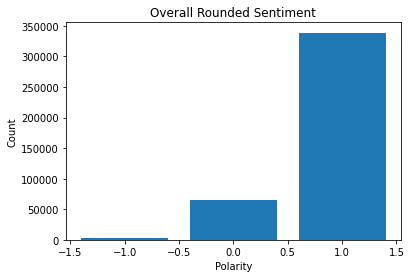

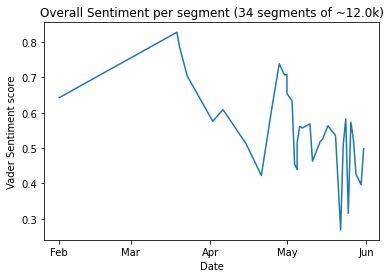

In [6]:
print("Applying overall sentiment analysis on segments over time...")
# load cleaned tweet corpus data
df = pd.read_csv(DATA_IN)
df = df.drop("Unnamed: 0", axis=1)

df = clean_sentiment_data(df)

df = sentiment_polarity_score(df)
# segments
df, sub_dfs, num_segments = split_data_segments(df)
num_tweets_per_segment = round(len(sub_dfs[0]) / 1000, 1)
avg_sentiment = sentiment_per_segment(df, sub_dfs, num_segments, num_tweets_per_segment)

In [7]:
df

,created_at,id,cleaned_tweet,date,time,neg,neu,pos,compound,rounded_polarity
407488,2021-02-01 03:58:29+00:00,1356089513857208320,nft friends,2021-02-01,03:58:29,0.000,0.244,0.756,0.4767,1
407487,2021-02-01 09:29:19+00:00,1356172769424244736,how are nft rates determined? higher nft chanc...,2021-02-01,09:29:19,0.153,0.589,0.258,0.3736,1
407486,2021-02-01 10:49:53+00:00,1356193045817872384,a great project,2021-02-01,10:49:53,0.000,0.328,0.672,0.6249,1
407485,2021-02-01 11:05:55+00:00,1356197080272752640,join gays dena,2021-02-01,11:05:55,0.000,0.476,0.524,0.2960,1
407484,2021-02-01 11:31:45+00:00,1356203583193063424,dena great,2021-02-01,11:31:45,0.000,0.196,0.804,0.6249,1
...,...,...,...,...,...,...,...,...,...,...
4,2021-05-31 23:58:44+00:00,1399515723274280960,"nice to find this project, this project will b...",2021-05-31,23:58:44,0.000,0.659,0.341,0.8860,1
3,2021-05-31 23:58:47+00:00,1399515734007447552,i am participating in the cryptoultraman nft a...,2021-05-31,23:58:47,0.000,1.000,0.000,0.0000,0
2,2021-05-31 23:59:35+00:00,1399515936093204480,such a beautiful project and congratulations t...,2021-05-31,23:59:35,0.000,0.463,0.537,0.9677,1
1,2021-05-31 23:59:40+00:00,1399515957362450432,great project! reset,2021-05-31,23:59:40,0.000,0.313,0.687,0.6588,1


In [8]:
import numpy as np

df['Log returns'] = np.log(df['compound']/df['compound'].shift())
df

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,created_at,id,cleaned_tweet,date,time,neg,neu,pos,compound,rounded_polarity,Log returns
407488,2021-02-01 03:58:29+00:00,1356089513857208320,nft friends,2021-02-01,03:58:29,0.000,0.244,0.756,0.4767,1,NaN
407487,2021-02-01 09:29:19+00:00,1356172769424244736,how are nft rates determined? higher nft chanc...,2021-02-01,09:29:19,0.153,0.589,0.258,0.3736,1,-0.243702
407486,2021-02-01 10:49:53+00:00,1356193045817872384,a great project,2021-02-01,10:49:53,0.000,0.328,0.672,0.6249,1,0.514406
407485,2021-02-01 11:05:55+00:00,1356197080272752640,join gays dena,2021-02-01,11:05:55,0.000,0.476,0.524,0.2960,1,-0.747232
407484,2021-02-01 11:31:45+00:00,1356203583193063424,dena great,2021-02-01,11:31:45,0.000,0.196,0.804,0.6249,1,0.747232
...,...,...,...,...,...,...,...,...,...,...,...
4,2021-05-31 23:58:44+00:00,1399515723274280960,"nice to find this project, this project will b...",2021-05-31,23:58:44,0.000,0.659,0.341,0.8860,1,0.349125
3,2021-05-31 23:58:47+00:00,1399515734007447552,i am participating in the cryptoultraman nft a...,2021-05-31,23:58:47,0.000,1.000,0.000,0.0000,0,-inf
2,2021-05-31 23:59:35+00:00,1399515936093204480,such a beautiful project and congratulations t...,2021-05-31,23:59:35,0.000,0.463,0.537,0.9677,1,inf
1,2021-05-31 23:59:40+00:00,1399515957362450432,great project! reset,2021-05-31,23:59:40,0.000,0.313,0.687,0.6588,1,-0.384502


In [17]:
df['Log returns'].std(ddof=0)

nan

In [19]:
!pip3 install pandas_datareader

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 109 kB 4.4 MB/s            
     |████████████████████████████████| 4.5 MB 147 kB/s            
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [20]:
import pandas_datareader as pdr
import datetime as dt

ticker = "AAPL"
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2020, 12, 31)

data = pdr.get_data_yahoo(ticker, start, end)

print(data.head())

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-01-02  39.712502  38.557499  38.722500  39.480000  148158800.0  38.326294
2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0  34.508709
2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0  35.981861
2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0  35.901772
2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0  36.586174


In [21]:
import numpy as np

data['Log returns'] = np.log(data['Close']/data['Close'].shift())

In [22]:
data

,High,Low,Open,Close,Volume,Adj Close,Log returns
Date,,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.326294,NaN
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.508709,-0.104924
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,35.981861,0.041803
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.901772,-0.002228
2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.586174,0.018884
...,...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.161407,0.007683
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,135.852509,0.035141
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.043640,-0.013404
